# Prosper Loan Data — Part II: Exploratory Data Analysis
## by Luca Scarpantonio

## Investigation Overview

The goal of this presentation is to explain how borrower risk and socio-economic factors influence:

- **BorrowerAPR (interest rate)**
- **LoanOriginalAmount (loan size)**
- **LoanStatus (performance)**

The analysis highlights three key insights:

1. **Risk-Based Pricing:** Higher ProsperScore leads to lower BorrowerAPR, confirming Prosper's risk-based pricing model.  
2. **Socio-Economic Factors:** Borrowers with lower income or unstable employment face higher interest rates.  
3. **Loan Term & Risk:** 60-month loans are larger but show a higher share of charged-off loans compared to 36-month loans.

These insights were selected from the exploratory analysis (Part I) and polished to form a clear narrative.

In [27]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [28]:
# load in the dataset into a pandas dataframe

loans = pd.read_csv('data/prosperLoanData.csv')

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Dataset Overview

The dataset comes from **Prosper**, a peer-to-peer lending platform, and includes loan-level records with borrower demographics, credit risk scores, loan terms, and performance outcomes.

- **Number of observations:** ~20,000 (post-2009 loans, filtered for complete `ProsperScore`)
- **Number of features:** 81 columns (a selected subset used here)
- **Key variables:**  
  - `BorrowerAPR` – interest rate charged to the borrower  
  - `ProsperScore` – internal risk score (1–10)  
  - `LoanOriginalAmount` – loan size in USD  
  - `Term` – loan duration (12, 36, or 60 months)  
  - `LoanStatus` – loan outcome (Completed, Current, Chargedoff, etc.)  
  - `IncomeRange`, `EmploymentStatus` – socio-economic indicators  



### Data wrangling steps included:
- Excluding pre-2009 loans to ensure `ProsperScore` completeness
- Removing rows with missing key fields (APR, Loan Amount, Loan Status)
- Dropping `"Not displayed"` income range to reduce noise

In [29]:
# Data Cleaning
# 1. Exclude loans before 2009 to ensure ProsperScore completeness
loans = loans[loans['ListingCreationDate'] >= '2009-01-01']

# 2. Remove rows with missing key fields
key_columns = ['BorrowerAPR', 'LoanOriginalAmount', 'LoanStatus']
loans = loans.dropna(subset=key_columns)

# 3. Drop rows where IncomeRange is "Not displayed"
if 'IncomeRange' in loans.columns:
    loans = loans[loans['IncomeRange'] != 'Not displayed']

# Reset index after filtering
loans_clean = loans.reset_index(drop=True)

print(f"Dataset cleaned. Remaining records: {len(loans_clean)}")
loans_clean.head()

Dataset cleaned. Remaining records: 84881


,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
1,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
2,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20
3,0F05359734824199381F61D,1074836,2013-12-14 08:26:37.093000000,NaN,60,Current,NaN,0.15425,0.1314,0.1214,...,-25.33,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
4,0F0A3576754255009D63151,750899,2013-04-12 09:52:56.147000000,NaN,36,Current,NaN,0.31032,0.2712,0.2612,...,-22.95,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


## Visualization 1 — BorrowerAPR Distribution

This plot shows the distribution of BorrowerAPR (interest rate) across all loans.

- **Shape:** The distribution is right-skewed, with most loans between **10% and 30%** APR.  
- **Mean APR:** Dashed line at ~21% highlights the central tendency.

**Observation:**  
The wide spread indicates significant variation in borrower risk.  
This motivates examining factors (like ProsperScore) that explain this variability.

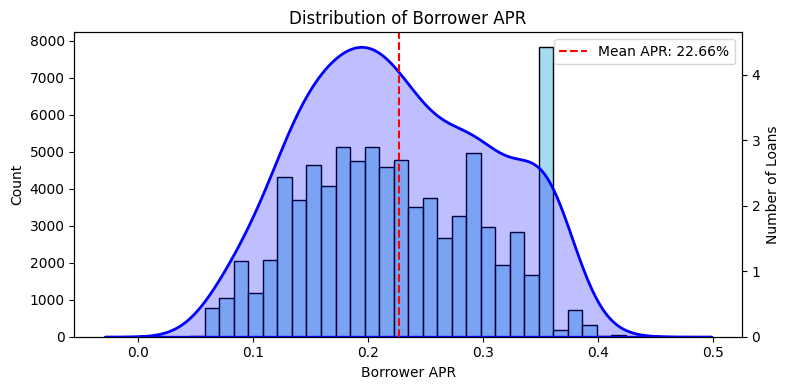

In [30]:
fig, ax1 = plt.subplots(figsize=(8,4))

# Istogramma sui conteggi (asse sinistro)
sns.histplot(loans_clean['BorrowerAPR'], bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_ylabel("Count")
ax1.set_xlabel("Borrower APR")

# Secondo asse per la densità
ax2 = ax1.twinx()
sns.kdeplot(loans_clean['BorrowerAPR'], bw_adjust=3, color='blue', fill='blue', ax=ax2, lw=2)
ax2.set_ylabel("Density")
ax2.grid(False)  # per non duplicare la griglia

# Add mean line
mean_apr = loans['BorrowerAPR'].mean()
plt.axvline(mean_apr, color='red', linestyle='--', linewidth=1.5, label=f"Mean APR: {mean_apr:.2%}")

# Titles and labels
plt.title("Distribution of Borrower APR")
plt.xlabel("Borrower APR")
plt.ylabel("Number of Loans")
plt.legend()
plt.tight_layout()
plt.show()

## Visualization 2 — BorrowerAPR by ProsperScore

This violin plot shows how APR changes across ProsperScore levels (1–10).

- **Clear negative trend:** Higher ProsperScore (lower credit risk) → lower median APR.  
- **Spread:** High-risk borrowers (score 1–3) have more variability in APRs.

**Observation:**  
This confirms Prosper's **risk-based pricing model**: safer borrowers receive cheaper loans.

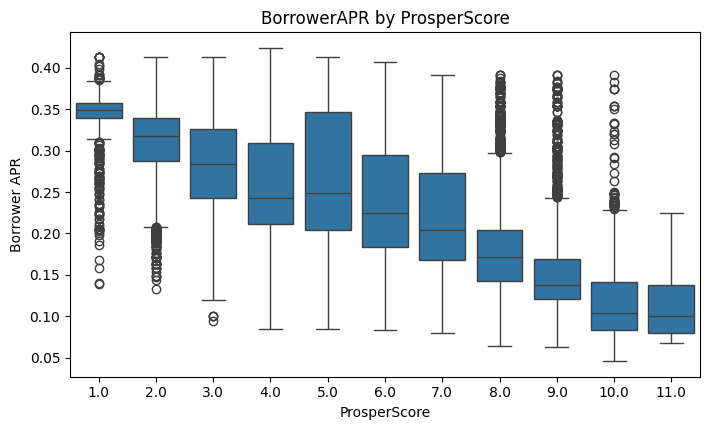

In [31]:
plt.figure(figsize=(7.2, 4.4))
sns.boxplot(
    data=loans_clean, x='ProsperScore', y='BorrowerAPR'
)
plt.title("BorrowerAPR by ProsperScore")
plt.xlabel("ProsperScore")
plt.ylabel("Borrower APR")
plt.tight_layout()
plt.show()

## Visualization 3 — Loan Status by Term

This countplot shows the distribution of loan statuses, split by loan term (36 vs 60 months).

- **Most loans:** Completed or Current.  
- **Risk signal:** 60-month loans have a slightly higher proportion of **Chargedoff** and **Past Due**.

**Observation:**  
Loan term is not just a maturity choice — it is associated with both **larger loan amounts** and **slightly higher risk**, which must be considered in pricing.


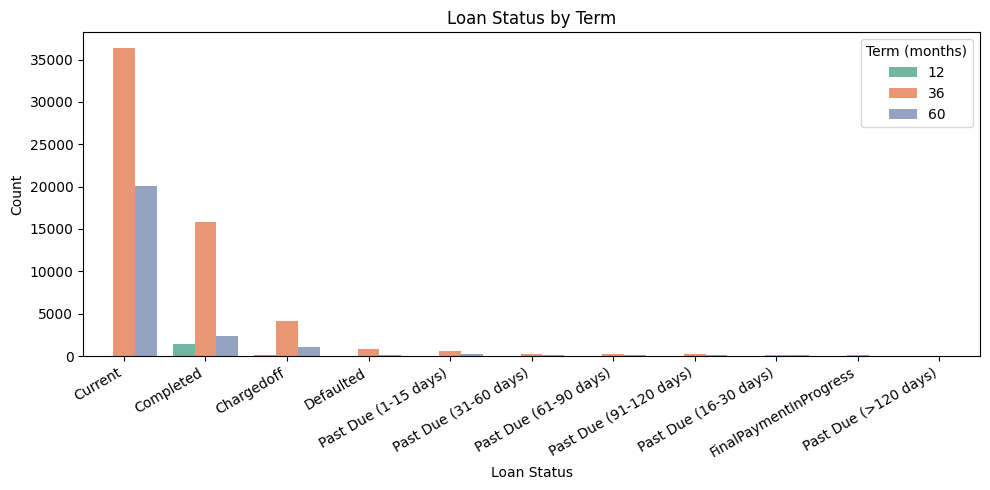

In [32]:
plt.figure(figsize=(10, 5))
order_ls = loans['LoanStatus'].value_counts().index
sns.countplot(
    data=loans, x='LoanStatus', hue='Term',
    order=order_ls, palette='Set2'
)
plt.xticks(rotation=30, ha='right')
plt.title("Loan Status by Term")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.legend(title="Term (months)")
plt.tight_layout()
plt.show()

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [33]:
!jupyter nbconvert Part_II_slide.ipynb --to slides --post serve --no-input --no-prompt

^C
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pathlib/_local.py", line 231, in __str__
    return self._str
AttributeError: 'pathlib._local.PosixPath' object has no attribute '_str'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pathlib/_local.py", line 293, in drive
    return self._drv
AttributeError: 'pathlib._local.PosixPath' object has no attribute '_drv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/nbconvert/nbconvertapp.py", line 193, in <module>
    class NbConvertApp(JupyterApp):
  File "/Libr

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 